In [1]:
import numpy as np
from Load_data import load_data

In [12]:
data = load_data("Data/20242025premierleague.csv")
data

Data loaded successfully from Data/20242025premierleague.csv


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,E0,16/08/2024,20:00,Man United,Fulham,1,0,H,0,0,...,1.86,2.07,1.83,2.11,1.88,2.11,1.82,2.05,1.90,2.08
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,...,2.05,1.88,2.04,1.90,2.20,2.00,1.99,1.88,2.04,1.93
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,...,2.02,1.91,2.00,1.90,2.05,1.93,1.99,1.87,2.02,1.96
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,...,1.87,2.06,1.86,2.07,1.92,2.10,1.83,2.04,1.88,2.11
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,...,1.87,2.06,1.88,2.06,1.89,2.10,1.82,2.05,1.89,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,25/05/2025,16:00,Newcastle,Everton,0,1,A,0,0,...,2.00,1.85,2.01,1.90,2.01,1.95,1.95,1.91,1.93,2.05
376,E0,25/05/2025,16:00,Nott'm Forest,Chelsea,0,1,A,0,0,...,1.80,2.05,1.86,2.08,1.86,2.08,1.81,2.05,1.86,2.14
377,E0,25/05/2025,16:00,Southampton,Arsenal,1,2,A,0,1,...,2.03,1.83,2.04,1.87,2.07,1.87,2.03,1.83,2.06,1.89
378,E0,25/05/2025,16:00,Tottenham,Brighton,1,4,A,1,0,...,1.95,1.90,2.00,1.93,2.01,1.93,1.95,1.89,2.06,1.93


In [ ]:
# Importerer alle seasons og sæt dem sammen (men skipper 2004/2005)
from pathlib import Path
import pandas as pd

files = sorted(Path("Data").glob("*premierleague.csv"))

dfs = []

for f in files:
    if "20042005" in f.name:
        continue  # skip problematic season

    season = f.stem.replace("premierleague", "")
    tmp = pd.read_csv(
        f,
        engine="python",
        on_bad_lines="skip"
    )
    tmp["season"] = season
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True, sort=False)

df.shape


(8196, 205)

8196 matches

In [ ]:
# Liste over de præcise sæsoner vi har med ift. filnavn.
df["season"].unique()

array(['20032004', '20052006', '20062007', '20072008', '20082009',
       '20092010', '20102011', '20112012', '20122013', '20132014',
       '20142015', '20152016', '20162017', '20172018', '20182019',
       '20192020', '20202021', '20212022', '20222023', '20232024',
       '20242025', '20252026'], dtype=object)

In [24]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# ------------------------------------------------------------
# 1) Select raw match features (home / away)
# ------------------------------------------------------------

raw_match_features = [
    "HS", "AS",      # Shots
    "HST", "AST",    # Shots on target
#    "HHW", "AHW",    # Hit woodwork
    "HC", "AC",      # Corners
    "HF", "AF",      # Fouls committed
#    "HFKC", "AFKC",  # Free kicks conceded
#    "HO", "AO",      # Offsides
    "HY", "AY",      # Yellow cards
    "HR", "AR"       # Red cards
]

# Ensure all selected columns exist and are numeric
X_raw = df[raw_match_features].apply(pd.to_numeric, errors="coerce")

# Drop rows with missing match statistics
X_raw = X_raw.dropna()

# ------------------------------------------------------------
# 2) Construct difference-based (balance / dominance) features
# ------------------------------------------------------------

X_diff = pd.DataFrame({
    "shot_diff":      X_raw["HS"]  - X_raw["AS"],
    "sot_diff":       X_raw["HST"] - X_raw["AST"],
#    "woodwork_diff":  X_raw["HHW"] - X_raw["AHW"],
    "corner_diff":    X_raw["HC"]  - X_raw["AC"],
    "foul_diff":      X_raw["HF"]  - X_raw["AF"],
#    "fk_conc_diff":   X_raw["HFKC"] - X_raw["AFKC"],
#    "offside_diff":   X_raw["HO"]  - X_raw["AO"],
    "yellow_diff":    X_raw["HY"]  - X_raw["AY"],
    "red_diff":       X_raw["HR"]  - X_raw["AR"],
}, index=X_raw.index)

# ------------------------------------------------------------
# 3) Construct intensity / tempo features (totals)
# ------------------------------------------------------------

X_total = pd.DataFrame({
    "shots_total":    X_raw["HS"]  + X_raw["AS"],
    "sot_total":      X_raw["HST"] + X_raw["AST"],
    "corners_total":  X_raw["HC"]  + X_raw["AC"],
    "fouls_total":    X_raw["HF"]  + X_raw["AF"],
    "yellow_total":   X_raw["HY"]  + X_raw["AY"],
    "red_total":      X_raw["HR"]  + X_raw["AR"],
}, index=X_raw.index)

# ------------------------------------------------------------
# 4) Final feature matrix for clustering
# ------------------------------------------------------------

X = pd.concat([X_diff, X_total], axis=1)

# ------------------------------------------------------------
# 5) Scale features (CRUCIAL for DBSCAN)
# ------------------------------------------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# 6) DBSCAN clustering
# ------------------------------------------------------------

db = DBSCAN(
    eps=0.9,          # tune later
    min_samples=6     # tune later
)

clusters = db.fit_predict(X_scaled)

# Attach cluster labels to original dataframe
df = df.copy()
df.loc[X.index, "cluster"] = clusters

# ------------------------------------------------------------
# 7) Ground truth (kept separate!)
# ------------------------------------------------------------

y = df.loc[X.index, "FTR"]   # or "Res"

# Example evaluation: cluster composition
cluster_summary = pd.crosstab(
    df.loc[X.index, "cluster"],
    y,
    normalize="index"
)

print(cluster_summary)

FTR             A         D         H
cluster                              
-1.0     0.300403  0.244108  0.455489
 0.0     0.000000  0.000000  1.000000


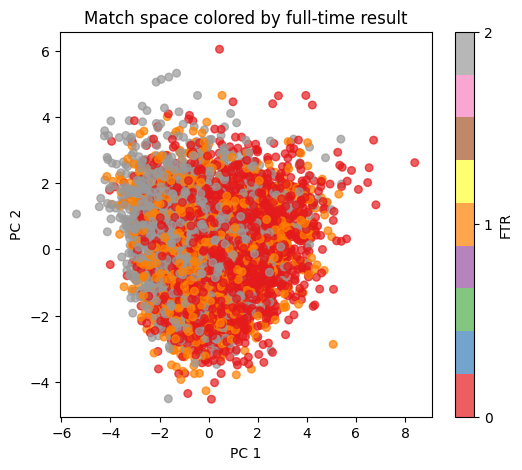

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


ftr_map = {"H": 0, "D": 1, "A": 2}
colors = df.loc[X.index, "FTR"].map(ftr_map)

plt.figure(figsize=(6,5))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=colors,
    cmap="Set1",
    s=30,
    alpha=0.7
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Match space colored by full-time result")
plt.colorbar(ticks=[0,1,2], label="FTR")
plt.show()

Chattens læsning:
The colors are heavily overlapping --> That tells you something fundamental:

There is no clean linear or low-dimensional separation between H / D / A outcomes based only on match statistics --> This is not a failure. It’s a truth about football.

Interpretation:
	•	Similar match styles can end differently
	•	Randomness, timing, penalties, red cards, finishing quality matter
	•	Match process ≠ match outcome

Rougly maps to:
            Chaotic
               ↑
   Away dom  ←   →  Home dom
               ↓
            Calm